In [1]:
from scipy.optimize import minimize
from joblib import Parallel, delayed, parallel_backend
from multiprocessing import cpu_count, Pool
from numpy.linalg import inv, det
from astropy.io import ascii
from scipy.optimize import minimize, rosen, rosen_der
from scipy import interpolate
from scipy.optimize import minimize

import numpy as np
import matplotlib.pyplot as plt
import emcee
import multiprocessing
import corner

In [2]:
# Fourier function, Eq. 8 in the paper
def function_fourier_fit(a, t):
    
    ret = a[0] + a[1]*np.sin(2*np.pi*(t)) + a[2]*np.cos(2*np.pi*(t))
    i = 0

    for deg in range(3, len(a),2):
        i+=1
        ret += a[deg]*np.sin(2*(i+1)*np.pi*(t)) + a[deg+1]*np.cos(2*(i+1)*np.pi*(t))

    return ret


# Log-normal distribution
def ln_normal(dy, std):
    return -0.5 * (dy)**2 / std**2 - 0.5*np.log(2*np.pi) - np.log(std)

# BH-Aur     --- RRab type

In [3]:
name_star = "BH-Aur"


# Spectroscopic data obtained from the analysis of APOGEE subvisits
line_of_sight_velocity = np.array([54.1, 56.4, 57.5, 60.2]) # corr for Heliocentric vel.
uncertainty_line_of_sight_velocity = np.array([1.2, 2.2, 3.7, 13.9])      
time_of_observations = np.array([2457428.816665, 2457428.828389, 2457428.8401, 2457428.851875]) # HJD


# Photometric information on BH Aur
amplitude_Vband             = 0.852168 # mag
uncertainty_amplitude_Vband = 0.004253 # mag
pulsation_period            = 0.456073 # day
time_of_brighness_maxima    = 2457388.958666 # day


# 'Ground truth' from Gaia data
gaia_vsys, error_gaia_vsys = 51.393063, 1.4457822

## Amplitude scaling relation

In [4]:
# Equation 6 in the paper
scaling_relation = 73.  

# Equation 6 in the paper
error_on_scaling = 1.

## Template and scatter in template

In [5]:
# Table 2, first row in the paper
template_fourier = np.array([-0.0000, -0.2736, -0.3116, -0.0560, 
                             -0.1544, 0.0099, -0.0976, 0.0399, 
                             -0.0421, 0.0237, 0.0041]) 

# Table B3, first column in the paper
phase_for_scatter_in_template = np.array([0.000, 0.025, 0.075, 0.125, 
                                          0.175, 0.225, 0.275, 0.325, 
                                          0.375, 0.425, 0.475, 0.525, 
                                          0.575, 0.625, 0.675, 0.725, 
                                          0.775, 0.825, 0.875, 0.925, 
                                          0.975, 1.000])  

# Table B3, second column in the paper
scatter_in_template = np.array([0.068, 0.068, 0.083, 0.056, 
                                0.035, 0.079, 0.046, 0.051, 
                                0.056, 0.038, 0.065, 0.045, 
                                0.063, 0.071, 0.067, 0.080, 
                                0.063, 0.052, 0.211, 0.209, 
                                0.073, 0.073,])            


# Spline function that interpolates the discrete scatter along the pulsation phase
f_spline_err = interpolate.interp1d(phase_for_scatter_in_template, 
                                    scatter_in_template, 
                                    kind='linear')

In [16]:
vector = amplitude_Vband

Amp_line_of_sight_vel = scaling_relation * vector # scaling_relation[0] * amplitude_Vband + scaling_relation[1]
uncertainty_Amp_line_of_sight_vel = np.sqrt(vector * error_on_scaling * vector 
                                      + (scaling_relation**2)*(uncertainty_amplitude_Vband**2) )

print(r"Predicted amplitude of the line of sight velocity and its error is: %.1f ± %.1f kms-1" %(Amp_line_of_sight_vel, 
                                                                                           uncertainty_Amp_line_of_sight_vel))

Predicted amplitude of the line of sight velocity and its error is: 62.2 ± 0.9 kms-1


In [13]:
def systematic_velocity_determ(param, HJD, measured_velocity, uncertainty_measured_velocity, P, M0, Alos, eAlos):
    
    vsys = param

    # Equation 18 in paper
    phase_star = np.mod(HJD - M0, P) / P
    
    # Equation 16 in paper
    model_velocity = function_fourier_fit(template_fourier, phase_star)*Alos + vsys

    # Equation 17 in paper
    evel_fin = np.sqrt(uncertainty_measured_velocity**2 
                       + (f_spline_err(phase_star)*Alos)**2 
                       + (function_fourier_fit(template_fourier,phase_star)*eAlos)**2 )

    # Equation 15 in paper
    result = ln_normal(measured_velocity - model_velocity, evel_fin) 

    
    return np.nansum(result[np.isfinite(result)])


# Possibility for including some priors
def prior(param):
    # pick a prior
    return 0.

#    
def LOG_probability(param, HJD, measured_velocity, uncertainty_measured_velocity, P, M0, Alos, eAlos):
    
    lp = prior(param)
    
    rety = systematic_velocity_determ(param, HJD, measured_velocity, 
                                      uncertainty_measured_velocity, 
                                      P, M0, Alos, eAlos) 

    return lp + rety


def LOG_minus(param, HJD, measured_velocity, uncertainty_measured_velocity, P, M0, Alos, eAlos):
    return -LOG_probability(param, HJD, measured_velocity, uncertainty_measured_velocity, P, M0, Alos, eAlos)

# --- Scipy way ---

In [14]:
p0 = np.array([-11.])

res = minimize(LOG_minus, x0=p0, args=(time_of_observations, 
                                      line_of_sight_velocity, 
                                      uncertainty_line_of_sight_velocity, 
                                      pulsation_period, 
                                      time_of_brighness_maxima, 
                                      Amp_line_of_sight_vel, 
                                      uncertainty_Amp_line_of_sight_vel), method='BFGS') #SLSQP


print("Determined systemic velocity and its uncertainty is: %.1f ± %.1f kms-1" %(res.x[0], np.sqrt(np.diag(res.hess_inv))[0]))

Determined systemic velocity and its uncertainty is: 48.8 ± 2.1 kms-1


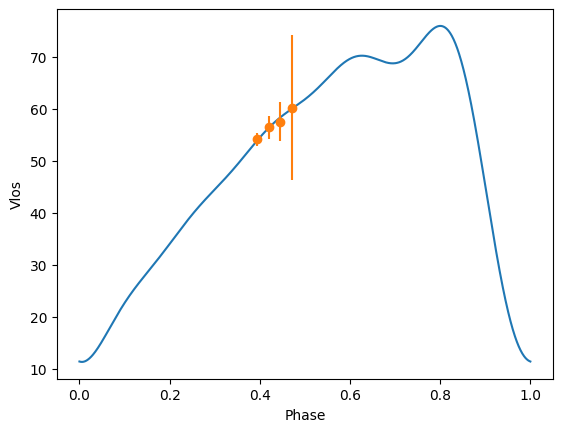

In [15]:
phase_star = np.mod(time_of_observations - time_of_brighness_maxima, pulsation_period) / pulsation_period

phase_star_model = np.linspace(0, 1, 1000)

model_velocity_rrab1 = function_fourier_fit(template_fourier, phase_star_model)*Amp_line_of_sight_vel + res.x[0]

plt.plot(phase_star_model, model_velocity_rrab1)
plt.errorbar(phase_star, line_of_sight_velocity, yerr=uncertainty_line_of_sight_velocity, fmt="o")
plt.xlabel("Phase")
plt.ylabel("Vlos")
plt.show()